# Electrode balancing

In this notebook we provide an example on how to perform electrode balancing for a half cell. The goal is to find the conversion from capacity to stoichiometry for a given measured electrode, by using a reference dataset for which voltage is known as a function of the stoichiometry.

## Set the environment
We start by installing and importing the necessary libraries.

In [ ]:
%pip install --upgrade pip ipywidgets -q
%pip install pybop -q

# Import the necessary libraries
import numpy as np
import pandas as pd
import pybamm

import pybop

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


2024-08-25 20:39:18.850 - [WARNING] citations.read_citations(76): Citations could not be read because the 'pybtex' library is not installed. Install 'pybamm[cite]' to enable citation reading.


## Load the data
We start by loading the data, which is available in the [pybamm-param repository](https://www.github.com/paramm-team/pybamm-param). We load half cell data (which is the versus stoichiometry and thus the reference one) and the three-electrode data (which is the one we want to balance). The measurements are for an LGM50 cell, with a graphite and SiOx negative electrode and an NMC811 positive electrode.

In [ ]:
#  .csv files are uploaded for Anode
base_url = "https://raw.githubusercontent.com/paramm-team/pybamm-param/develop/pbparam/input/data/"
reference_data = pd.read_csv(
    base_url + "anode_OCP_2_lit.csv"
)  # half cell lithiation data
measured_data = pd.read_csv(
    base_url + "anode_OCP_3_lit.csv"
)  # three-electrode full cell lithiation data

# Drop negative capacity values
measured_data = measured_data.drop(
    measured_data[measured_data["Capacity [A.h]"] < 0].index
)

## Setup model, parameters and data

To perform the electrode balancing, we will use an ECM model consisting only of the OCV component. To achieve that, we will set the resistance to zero. We will also change the upper and lower voltage limits to ensure we do not hit them during the optimisation. For the OCV, we will use the reference data we just loaded.

In [ ]:
def ocv(sto):
    return pybamm.Interpolant(
        reference_data["Stoichiometry"].to_numpy(),
        reference_data["Voltage [V]"].to_numpy(),
        sto,
        "reference OCV",
    )


parameter_set = pybop.empirical.Thevenin().default_parameter_values
parameter_set.update(
    {
        "Initial SoC": 0,
        "Entropic change [V/K]": 0,
        "R0 [Ohm]": 0,
        "Lower voltage cut-off [V]": 0,
        "Upper voltage cut-off [V]": 5,
        "Open-circuit voltage [V]": ocv,
    }
)

Now we can just assemble the model. We use the `Thevenin` model with no RC elements:

In [ ]:
model = pybop.empirical.Thevenin(
    parameter_set=parameter_set, options={"number of rc elements": 0}
)

We define the parameters we want to optimise. In this case, we need to optimise the initial SoC and the cell capacity, which will be needed to convert the capacity to stoichiometry.

In [ ]:
parameters = pybop.Parameters(
    pybop.Parameter(
        "Initial SoC",
        prior=pybop.Uniform(0, 0.5),
        bounds=[0, 0.5],
    ),
    pybop.Parameter(
        "Cell capacity [A.h]",
        prior=pybop.Uniform(0.01, 50),
        bounds=[0.01, 50],
    ),
)

Now we need to assemble the dataset. This is a bit tricky, as we are doing an electrode balancing but in theory we are solving a discharge problem. However, we can use that if we impose a 1 A discharge, the time (in hours) will be the same as the capacity in (in Ah). Therefore, we can treat time as capacity, we just need to scale it to the correct units (as PyBaMM models take time in seconds). Note that in this case current is negative as we are lithiating the electrode.

In [ ]:
# Form dataset
dataset = pybop.Dataset(
    {
        "Time [s]": measured_data["Capacity [A.h]"].to_numpy() * 3600,
        "Current function [A]": -np.ones(len(measured_data["Capacity [A.h]"])),
        "Voltage [V]": measured_data["Voltage [V]"].to_numpy(),
    }
)

## Identifying the parameters

Once we have defined the model, parameters and dataset, we can just proceed to the optimisation. We define the `FittingProblem` and the cost, for which we choose the sum squared error.

In [ ]:
problem = pybop.FittingProblem(model, parameters, dataset)
cost = pybop.SumSquaredError(problem)

We choose the `SciPyMinimize` optimiser and we solve the optimisation problem. We can then print and plot the results.

In [ ]:
optim = pybop.SciPyMinimize(cost, max_iterations=300)
x, final_cost = optim.run()
print("Initial parameters:", optim.x0)
print("Estimated parameters:", x)

Initial parameters: [ 0.28904323 22.82658721]
Estimated parameters: [0.00923883 4.97214911]


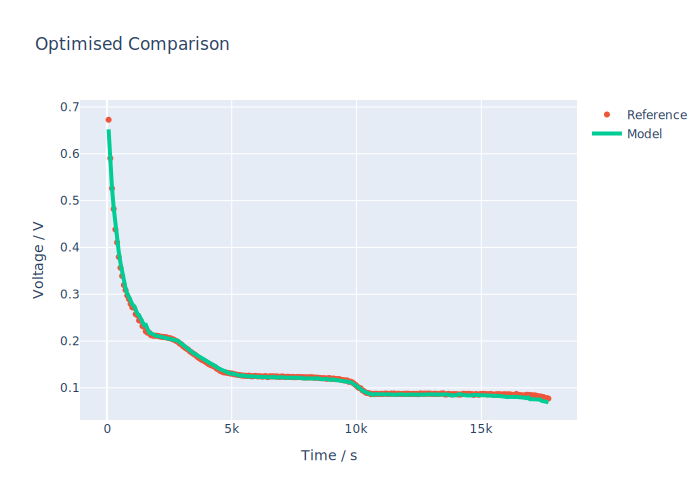

In [ ]:
pybop.quick_plot(problem, problem_inputs=x, title="Optimised Comparison");

## Converting capacity to stoichiometry

However, the whole goal of the electrode balancing was to convert capacity to stoichiometry, so how can we do that? To convert capacity $Q$ to stoichiometry $x$, we can simply use the following equation:

$$
x = \pm \frac{Q}{Q_{\text{cell}}} + x_0.
$$
Here, the choice of plus and minus depends on whether we are lithiating or delithiating the electrode (it is related to whether the current in the data is positive or negative). $Q_{\text{cell}}$ is the cell capacity and $x_0$ is the initial stoichiometry, which are the two parameters we fitted. We can now convert the measured data and plot it against the reference data to check that the electrode balancing was correct.

In [ ]:
from plotly import graph_objects as go

fig = go.Figure(
    layout=go.Layout(title="OCP Balance", width=800, height=600),
)

fig.add_trace(
    go.Scatter(
        x=reference_data["Stoichiometry"],
        y=reference_data["Voltage [V]"],
        mode="lines",
        name="reference",
    ),
)

Q = x[1]
sto_0 = x[0]

sto = measured_data["Capacity [A.h]"].to_numpy() / Q + sto_0

fig.add_trace(
    go.Scatter(x=sto, y=measured_data["Voltage [V]"], mode="lines", name="fitted"),
)

# Update axes labels
fig.update_xaxes(title_text="Stoichiometry")
fig.update_yaxes(title_text="Voltage [V]")

# Show figure
fig.show()